**Euler-Maruyama Solver**

In [2]:
import torch as th
from torch.optim.optimizer import Optimizer, required
from collections import defaultdict 
import numpy as np


class EulerMaruyama(Optimizer):
    def __init__(self,  param_groups, tau=required, mu=0, T=0, coupling=1, noise_cache=0):
        for n, d in enumerate(param_groups):
            tau = d['tau']
            if tau in [None, 0]:
                param_groups.pop(n)
        defaults = dict(tau=tau, mu=mu, coupling=coupling, T=T)
        super().__init__(param_groups, defaults)
        self.noise_cache = noise_cache
        if noise_cache:
            self.init_noise()
            self.noise_idx = 0
    def init_noise(self):
        for group in self.param_groups:
            scale = (2 * group['T'] * group['dt'] / group['tau'])**0.5
            if scale == 0:
                continue
            mu = group['mu']
            for p in group['params']:
                param_state = self.state[p]
                param_state['noise_scale'] = scale
                param_state['noise'] = th.FloatTensor(self.noise_cache, *p.shape).normal_(0, scale)
    def reset_noise(self, noise_cache=None):
        self.noise_idx = 0
        if noise_cache is not None:
            self.noise_cache = noise_cache
            self.init_noise()
            return
        for p, param_state in self.state.items():
            if 'noise_scale' in param_state:
                scale = param_state['noise_scale']
                param_state['noise'].normal_(0, scale)
    def step(self, closure, dt=1):
        # Half-step x if there is mass
        for group in self.param_groups:
            mu = group['mu']
            if mu == 0:
                continue
            tau = group['tau']
            du =  group['coupling'] * dt / tau

            for p in group['params']:
                param_state = self.state[p]
                if 'momentum' not in param_state:
                    param_state['momentum'] = th.zeros_like(p)
                pi = param_state['momentum']
                p.data.add_(du/(2 * mu), pi)

        energy = closure() 

        for group in self.param_groups:
            mu = group['mu']
            tau = group['tau']
            T = group['T']
            du =  group['coupling'] * dt / tau

            if group['params'][0].shape == (16, 8):
            #    print(du)
                pass
            if du == 0:
                continue

            for p in group['params']:
                p_grad = p.grad
                if T > 0:
                    if self.noise_cache:
                        eta = self.state[p]['noise'][self.noise_idx]
                    else:
                        eta = th.FloatTensor(p.shape).normal_()
                    if p.is_cuda:
                        eta = eta.to('cuda')

                if mu != 0:
                    # Step momentum if there is mass
                    pi = self.state[p]['momentum']
                    pi.add_(-du, pi/mu + p_grad)
                    
                    # Add noise if there is temperature
                    if T > 0:
                        pi.add_((2 * T * du)**0.5, eta)

                    # Half-step x
                    p.data.add_(du/(2 * mu), pi)
                else:
                    # If no mass, just step x
                    p.data.add_(-du, p_grad)
                    if T > 0:
                        p.data.add_((np.abs(2 * T * du))**0.5, eta)

        if self.noise_cache:
            self.noise_idx += 1
            if self.noise_idx >= self.noise_cache:
                self.reset_noise()
        return

**Energy Functions**

In [ ]:
# Poisson Energy Function
def E(s):
        batch_size = x.shape[0]
        lmbda = th.nn.functional.softplus(A@s)
        reconstruction_energy = th.sum((x*th.log(lmbda)-lmbda)[None, :],dim=1)
        sparsity_energy = SPARSITY_PENALTY * th.sum(s.abs()[None, :],dim=1)
        return reconstruction_energy + sparsity_energy
# Gaussian Energy Function
def E(s):
    return 0.5 * ((A @ s - x)**2 + SPARSITY_PENALTY * s.abs()).sum()

# L0 Energy Function
def E(s):
    return 0.5 * ((A @ s - x)**2).sum() + SPARSITY_PENALTY * (s > 0).sum() #L0 prior

# Spike & Slab Prior
def E(s):
  pass

**Simulations**

In [3]:
import numpy as np
import torch as th
from torch.nn import Parameter
import matplotlib.pylab as plt
import matplotlib.cm as cm
from tqdm import tqdm
import scipy.special

N_DICT = 2
N_DIM = 2
DT_SCALE = 5e-3# 1.5
TAU_SCALE = 1000
SPARSITY_PENALTY = 2
OUTMAX = 1000000000

# make du = 0.1 
# udot = de gradE + sqrt{2Tdu}eps
# make sure T == 1 

A = th.FloatTensor(N_DIM, N_DICT).normal_()
# A = th.tensor([[5., 1.], [5., -1.]])
A = th.tensor([[1., 0.], [0., 1.]])

def p(s, sigma):
    return np.exp(-1 * np.abs(s) / sigma) / (2 * sigma)

def ReLU(x):
    return x * (x > 0)

def E(s):
    return 0.5 * ((A @ s - x)**2).sum() + SPARSITY_PENALTY * s.abs().sum() #(s > 0).sum() #L0 prior

def dEds_langevin(s):
    return dt*(A.T@(x-A@s) - SPARSITY_PENALTY*th.sgn(s)) + th.sqrt(2*T*dt)*th.FloatTensor(s.shape).normal_()

def P(s):
    return th.exp(-E(s)/T)

# s = Parameter(th.FloatTensor(N_DICT).normal_()) #Change to L0
s = Parameter(th.ones([N_DICT,],dtype=th.float)) #Change to L0

NOISE_MEAN, NOISE_VARIANCE = 0 , 0.1
x = A@s + np.random.normal(NOISE_MEAN, NOISE_VARIANCE) # Additive Gaussian Noise
# x = th.ones_like(x) + 1e-2

U, Sigma, V = th.svd(A)
M = (Sigma.max())**2
m = (Sigma.min())**2
# dt = DT_SCALE/M
T = th.FloatTensor([1.0])
dt = th.FloatTensor([0.05])

tmax = int(5e4) #int(TAU_SCALE/m/dt)

# param_groups = [
#         {'params': [s], 'tau': 1, 'mu': 0, 'T': T, 'dt': dt},
#         ]
# solver = EulerMaruyama(param_groups)

# S = []
# s0 = Parameter(th.ones_like(s)) #Change to L0
# def closure():
#     energy = E(s)
#     energy.backward(retain_graph = True)
#     return energy

# S = np.zeros((tmax, N_DIM))
# for n in tqdm(range(tmax)):
#     solver.zero_grad()
#     solver.step(closure)
#     S[n] = s.data.numpy()

# if tmax > OUTMAX:
#     skip = int(tmax//OUTMAX)
#     S = S[::skip]

In [4]:
s_inference = th.ones_like(s) #Change to L0
# s_inference = th.zeros_like(s) #Change to L0
energies = []
S = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):

    energies.append(E(s_inference).item())
    s_inference += th.clone(dEds_langevin(s_inference))
    S.append(s_inference.data.numpy().copy())
S = np.asarray(S)
energies = np.asarray(energies)
if tmax > OUTMAX:
    skip = int(tmax//OUTMAX)
    S = S[::skip]

100%|██████████| 50000/50000 [00:02<00:00, 16752.87it/s]


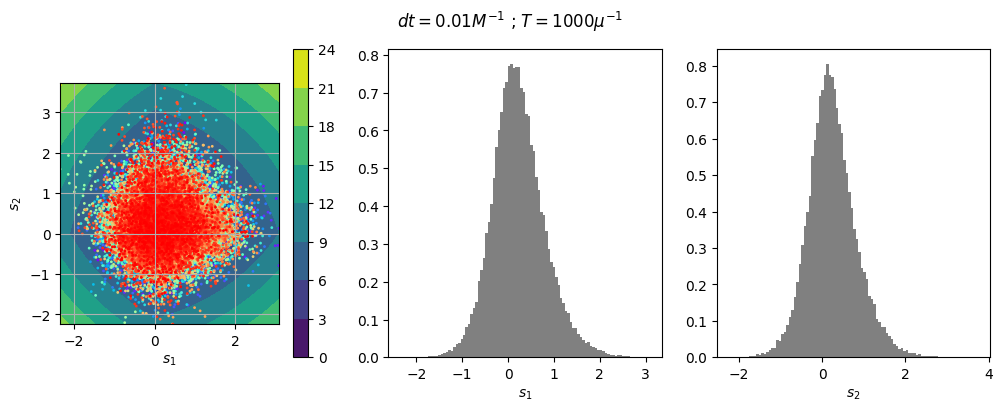

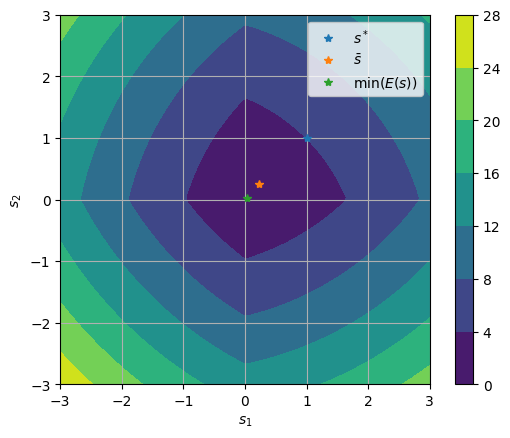

In [5]:
xlist = np.linspace(S[:,0].min(), S[:,0].max(), 100)
ylist = np.linspace(S[:,1].min(), S[:,1].max(), 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = E( th.tensor(Sgrid[i,:],dtype=th.float) )

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
V = np.array(V)
Sigma = np.array(1/Sigma)
S_ = S@V
levels = np.asarray([1,5,10,20,40,100])
cp = axes[0].contourf(X, Y, Z.reshape(X.shape)) #,levels)
fig.colorbar(cp) # Add a colorbar to a plot"
colors = cm.rainbow(np.linspace(0, 1, S.shape[0]))
axes[0].scatter(*S.T, color=colors, s=1)
# axes[0].plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# axes[0].plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$s_1$')
axes[0].set_ylabel(r'$s_2$')
axes[0].grid()
# axes[0].scatter(s.detach().cpu().numpy()[0],s.detach().cpu().numpy()[1],'*',s=10)

s_ = np.linspace(-3*Sigma[0], 3*Sigma[0])
var = 100 #Sigma[0]
p_ = p(s_, var)
axes[1].hist(S_[:, 0], fc='grey', bins=100, density=True)
# axes[1].plot(s_, p_, 'r--')
axes[1].set_xlabel(r'$s_1$')

s_ = np.linspace(-3*Sigma[1], 3*Sigma[1])
p_ = p(s_, Sigma[1])
axes[2].hist(S_[:, 1], fc='grey', bins=100, density=True)
# axes[2].plot(s_, p_, 'g--')
axes[2].set_xlabel(r'$s_2$')
plt.suptitle(rf'$dt = {DT_SCALE:.2f} M^{{-1}}$ ; $T = {TAU_SCALE} \mu^{{-1}}$')
plt.savefig(f'{TAU_SCALE}_{DT_SCALE}.pdf')
plt.show()

# plot the energy function on a smaller scale 
vmax=3
fig,ax = plt.subplots()
xlist = np.linspace(-vmax, vmax, 100)
ylist = np.linspace(-vmax, vmax, 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = E(th.tensor(Sgrid[i,:],dtype=th.float))

cp = ax.contourf(X, Y, (Z.reshape(X.shape)))#,levels)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmin(Z),),:].T,'*',label=r'$\min(E(s))$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()

In [6]:
np.argmin(Z)
X

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [7]:

Sgrid[(np.argmin(Z),),:].shape

(1, 2)

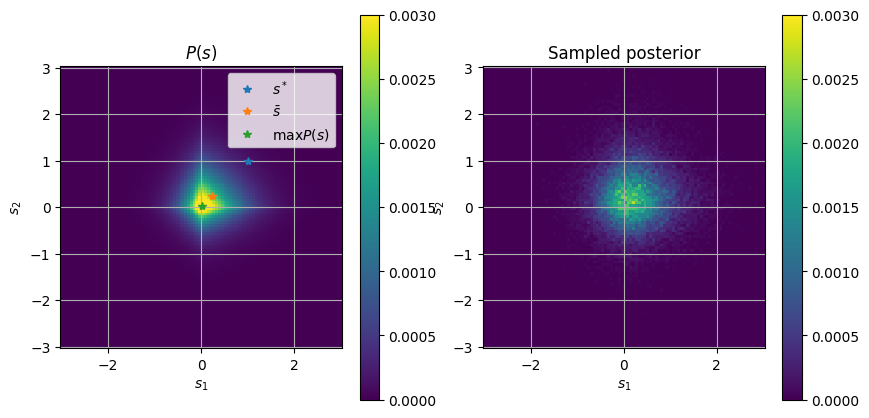

In [8]:
# plot the energy function on a smaller scale 
vmax=3
n_bins=100

fig,axs = plt.subplots(1,2,figsize=(10,5))
xlist = np.linspace(-vmax, vmax, n_bins)
ylist = np.linspace(-vmax, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = P(th.tensor(Sgrid[i,:],dtype=th.float))
pS_energy_function = Z.reshape(X.shape)
pS_energy_function /= np.sum(pS_energy_function)

ax = axs[0]
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=3e-3,vmin=0)#,levels)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Sgrid[(np.argmax(Z),),:].T,'*',label=r'$\max P(s)$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_title(r'$P(s)$')

pS_emperical, xedges, yedges = np.histogram2d(
    x=S[:,0],
    y=S[:,1],
    bins=n_bins,
    range=[[-vmax, vmax], [-vmax, vmax]],
    density=True,
)
pS_emperical = pS_emperical.T
pS_emperical /= np.sum(pS_emperical)

ax = axs[1]
cp = ax.pcolormesh(X, Y, pS_emperical,vmax=3e-3,vmin=0)
fig.colorbar(cp)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled posterior')
ax.set_aspect('equal')

In [9]:
def KLDivergence(p,q):
  p /= np.sum(p)
  q /= np.sum(q)

  vec = scipy.special.rel_entr(p, q)    
  kl_div = np.sum(vec)  
  return kl_div

print(KLDivergence(pS_emperical.flatten(),pS_energy_function.flatten()))

0.07888342795548946


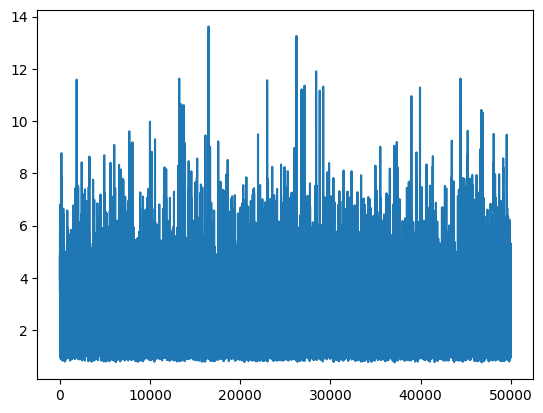

In [10]:
fig,ax = plt.subplots()

ax.plot(energies)

In [ ]:

x

tensor([1.0100, 1.0100])

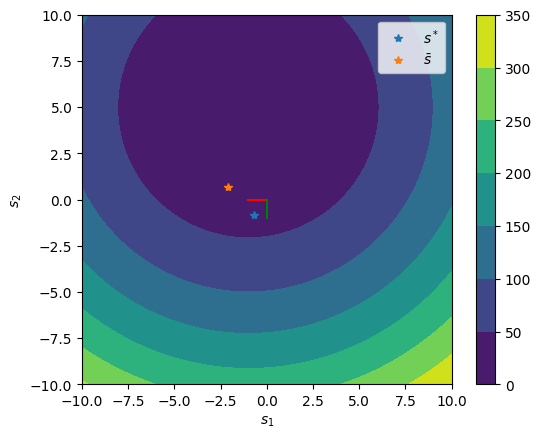

In [ ]:

vmax=10
fig,ax = plt.subplots()
xlist = np.linspace(-vmax, vmax, 100)
ylist = np.linspace(-vmax, vmax, 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = (Sgrid[i,0]+1)**2 +  (Sgrid[i,1]-5)**2

cp = ax.contourf(X, Y, (Z.reshape(X.shape)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = s.unsqueeze(0).detach().cpu().numpy().T
qbar = S
ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.set_aspect('equal')
ax.legend()

In [ ]:

S.mean(axis=0,keepdims=True)

array([[-0.0151996 ,  0.02259635]])

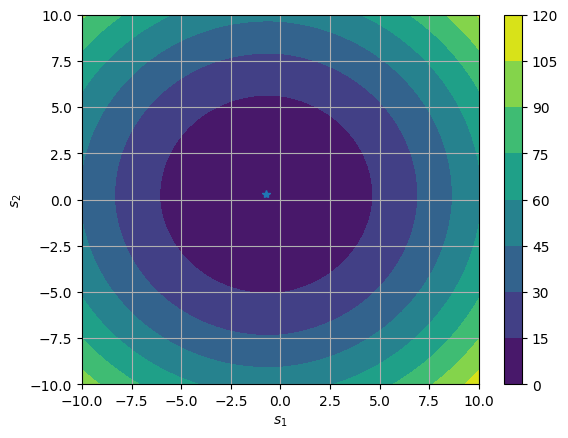

In [ ]:
fig,ax = plt.subplots()
cp = ax.contourf(X, Y, Z.reshape(X.shape).T)
fig.colorbar(cp) # Add a colorbar to a plot
# ax.plot([0, Sigma[0] * V[0, 0]], [0, Sigma[0] * V[1, 0]], 'r')
# ax.plot([0, Sigma[1] * V[0, 1]], [0, Sigma[1] * V[1, 1]], 'g')
q = x.unsqueeze(0).detach().cpu().numpy().T
ax.plot(*q,'*')
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()

* verify contour plots are correct 
  * Why arent they rotated for different As
* sample more and sweep through temperatures
  * does the pdf look like the energy function?

In [ ]:

x

tensor([ 0.5517, -1.4513], grad_fn=<AddBackward0>)

In [ ]:

q[0,(0,)].shape

(1,)

In [ ]:
plt.scatter?

In [ ]:
q = x.unsqueeze(0).detach().cpu().numpy().T
q.shape

(2, 1)

In [ ]:
S.T.shape

(2, 666)

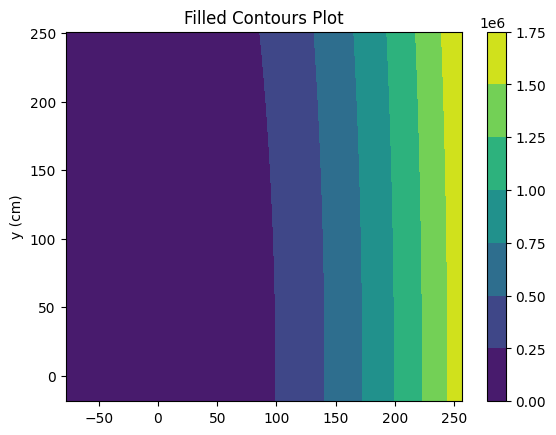

In [ ]:
xlist = np.linspace(S[:,0].min(), S[:,0].max(), 100)
ylist = np.linspace(S[:,1].min(), S[:,1].max(), 100)
X, Y = np.meshgrid(xlist, ylist)
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Sgrid.shape[0]])
for i in range(len(Z)):
  Z[i] = E(Sgrid[i,:])

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z.reshape(X.shape))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()


In [ ]:

S[0,:]

array([ 0.5340783 , -0.25896063])

In [ ]:

S[-1,:]

array([ 214.9906311 , -228.43186951])

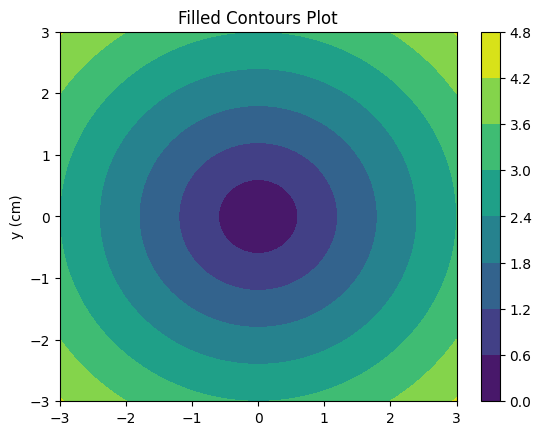

In [ ]:

xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [ ]:

Z.shape

(100, 100)

In [ ]:
Sgrid = np.asarray([X.flatten(),Y.flatten()]).T
Sgrid.shape

(10000, 2)

In [ ]:

tmax

16666

**Further Steps**
1. Add third-order term to Euler-Maruyama
2. Figure out where warmup is achieved, experiment with initialization methods.
3. Extend to more complicated dictionaries, and finally images
4. Implement Dictionary Learning alongside Inference.
5. Implement an L0-like sparsity term.
6. Implement Mirror Langevin Diffusion (first order) -(https://github.com/twmaunu/NLA/blob/main/code/mirrorLangevinMC.py)
7. Repeat for Poisson
8. Clean up Mike Fang's repository (time permitting)